In [1]:
import pandas as pd
import numpy as np

from scipy import stats

import json
import clustering
from clustering.what_if_model import WhatIfModel
from clustering.pqp_input_parser import PQPInputParser
from clustering.util import create_model
import autoreload
import clustering.evaluation

%load_ext autoreload
%autoreload 2
pd.set_option('display.max_colwidth', -1)

In [2]:
BASE_PATH_TPCH = "~/Dokumente/repos/example_plugin/stats/final/tpch/sf1-2d/"
TPCH_ORDERKEY = f"{BASE_PATH_TPCH}/l_orderkey"
TPCH_SHIPDATE = f"{BASE_PATH_TPCH}/l_shipdate"

In [18]:
m = create_model("lineitem", PQPInputParser("tpch", TPCH_ORDERKEY), 2)

cost_model_output/models/


In [ ]:
m.suggest_clustering(30)

In [25]:
CLUSTERING_COLUMN = "l_shipdate"
SIDED = True
join_results = clustering.evaluation.evaluate_join_step(m, TPCH_SHIPDATE, [CLUSTERING_COLUMN], CLUSTERING_COLUMN, [100], "ALL", SIDED)


print(f"There are {len(join_results)} joins")
join_results[['QUERY_HASH1', 'DESCRIPTION1', 'RUNTIME_BASE', 'RUNTIME_ESTIMATE', 'RUNTIME_CLUSTERED', 'TOTAL_ERROR', 'RELATIVE_ERROR']]

## Estimating ColumnBetween scans
dropping columns PREDICATE_BetweenInclusive, PREDICATE_BetweenUpperExclusive
## Estimating ColumnVsValue scans
dropping columns PREDICATE_Equals, PREDICATE_LessThan, PREDICATE_LessThanEquals

## Estimating REFERENCE DATA joins
## Estimating REFERENCE REFERENCE joins

383 joins with lineitem as probe or build side
There are 383 joins


,QUERY_HASH1,DESCRIPTION1,RUNTIME_BASE,RUNTIME_ESTIMATE,RUNTIME_CLUSTERED,TOTAL_ERROR,RELATIVE_ERROR
0,129f61e2f3ecf0ef,JoinHash (Inner Join where l_suppkey = s_suppkey) Radix bits: 0,133056,607877,93943,-513934,0.154543
1,140261541ac6b6ba,JoinHash (Semi Join where l_partkey = ps_partkey) Radix bits: 0,40331335,20394806,7227433,-13167373,0.354376
2,140261541ac6b6ba,JoinHash (Semi Join where l_suppkey = ps_suppkey) Radix bits: 0,10034815,7969108,2633815,-5335293,0.330503
3,140261541ac6b6ba,JoinHash (Semi Join where ps_suppkey = l_suppkey AND ps_availqty > 0.5 * SUM(l_quantity) AND ps_partkey = l_partkey) Radix bits: 0,5014509,3994570,3227365,-767205,0.807938
4,19ae7b7a1d3226b,JoinHash (Semi Join where l_orderkey = o_orderkey) Radix bits: 0,61011485,56044660,110399446,54354786,1.969848
5,19ae7b7a1d3226b,JoinHash (Semi Join where o_orderkey = l_orderkey) Radix bits: 1,31513583,28645288,25900705,-2744583,0.904187
6,20e42e320de74706,JoinHash (Inner Join where l_orderkey = o_orderkey) Radix bits: 0,14802628,15433713,14141189,-1292524,0.916253
7,20e42e320de74706,JoinHash (Semi Join where l_orderkey = o_orderkey) Radix bits: 1,133901784,140260710,109891527,-30369183,0.783480
8,21810eadacd14054,JoinHash (Inner Join where l_suppkey = s_suppkey) Radix bits: 0,46221779,55199349,80431969,25232620,1.457118
9,21810eadacd14054,JoinHash (Inner Join where o_orderkey = l_orderkey) Radix bits: 2,106201991,109760534,129079563,19319029,1.176011


In [27]:
join_results['e'] = join_results['TOTAL_ERROR'] ** 2
join_results.sort_values(['e'], ascending=False)[["QUERY_HASH1", "DESCRIPTION1", "RUNTIME_BASE", "RUNTIME_ESTIMATE", "RUNTIME_CLUSTERED", "RELATIVE_ERROR", "TOTAL_ERROR"]]
#join_results.sort_values(['e'], ascending=False)[['DESCRIPTION1', 'TOTAL_ERROR']]

,QUERY_HASH1,DESCRIPTION1,RUNTIME_BASE,RUNTIME_ESTIMATE,RUNTIME_CLUSTERED,RELATIVE_ERROR,TOTAL_ERROR
99,580bc766bcba5139,JoinHash (Semi Join where l_orderkey = o_orderkey) Radix bits: 2,184510856,178776534,298277571,1.668438,119501037
266,bfb403aee0d212a,JoinHash (Semi Join where l_orderkey = l_orderkey) Radix bits: 1,149228814,150054295,262177074,1.747215,112122779
220,a17cb368eadced8f,JoinHash (Semi Join where l_orderkey = l_orderkey) Radix bits: 1,141154570,134762643,246059459,1.825873,111296816
164,7324393c05ab5301,JoinHash (Semi Join where l_orderkey = l_orderkey) Radix bits: 1,134507626,134762643,244242282,1.812389,109479639
45,37e2ba0a1c4e865f,JoinHash (Semi Join where l_orderkey = l_orderkey) Radix bits: 1,146207983,150054295,258897116,1.725356,108842821
132,6730c267d3eac48a,JoinHash (Semi Join where l_orderkey = l_orderkey) Radix bits: 1,140117081,136205521,242880358,1.783190,106674837
147,6ec3126b032024be,JoinHash (Semi Join where l_orderkey = l_orderkey) Radix bits: 1,137909745,141332602,247066217,1.748119,105733615
278,c924415412bc1fe5,JoinHash (Semi Join where l_orderkey = o_orderkey) Radix bits: 2,181135908,183468287,288427499,1.572084,104959212
272,c2b1ab1624cdc91c,JoinHash (Semi Join where l_orderkey = o_orderkey) Radix bits: 2,178331389,178776534,283085972,1.583463,104309438
357,f0a40ffe87d431b1,JoinHash (Semi Join where l_orderkey = o_orderkey) Radix bits: 2,179018952,183468287,286870077,1.563595,103401790


There are 383 operators

66% of the operator estimates are over- or underestimated between factor 1 and 1.5
24% of the operator estimates are over- or underestimated between factor 1.5 and 3
8% of the operator estimates are over- or underestimated between factor 3 and 100

Total estimate: 17690 ms
Total measured: 21143 ms
MSE: 1350 ms^2
SMAPE: 37%


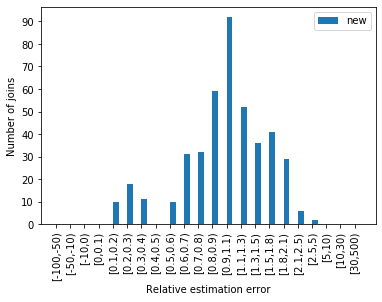

In [26]:
clustering.evaluation.print_aggregated_metrics(join_results, m.query_frequencies)
clustering.evaluation.plot_join_errors(join_results, None, m.query_frequencies)

In [19]:
CLUSTERING_COLUMN = "l_shipdate"
scan_results = clustering.evaluation.evaluate_scans(m, TPCH_SHIPDATE, [CLUSTERING_COLUMN], CLUSTERING_COLUMN, [100])
print(f"There are {len(scan_results)} scans on {m.table_name}")

scan_results[['QUERY_HASH', 'DESCRIPTION1', 'RUNTIME_BASE', 'RUNTIME_ESTIMATE', 'RUNTIME_CLUSTERED', 'TOTAL_ERROR', 'RELATIVE_ERROR']].sort_values(['TOTAL_ERROR'], ascending=False)

## Estimating ColumnBetween scans
dropping columns PREDICATE_BetweenInclusive, PREDICATE_BetweenUpperExclusive
## Estimating ColumnVsValue scans
dropping columns PREDICATE_Equals, PREDICATE_LessThan, PREDICATE_LessThanEquals

## Estimating REFERENCE DATA joins
## Estimating REFERENCE REFERENCE joins

There are 91 scans on lineitem


,QUERY_HASH,DESCRIPTION1,RUNTIME_BASE,RUNTIME_ESTIMATE,RUNTIME_CLUSTERED,TOTAL_ERROR,RELATIVE_ERROR
16,4e4cb5b90ba5de03,TableScan Impl: ColumnVsValue l_shipdate <= '1998-08-04',35531182,9005800,19950263,10944463,2.215268
28,5aa537e0d658225a,TableScan Impl: ColumnVsValue l_shipdate <= '1998-08-09',36069135,9005800,12639155,3633355,1.403446
56,9a1adec8eeee6ec1,TableScan Impl: ColumnVsValue l_shipdate <= '1998-08-27',37732442,9146026,12734215,3588189,1.392322
81,f16984c46aa94970,TableScan Impl: ColumnVsValue l_shipdate <= '1998-09-01',35514908,9146026,12684554,3538528,1.386892
32,6081c4fbd55e16ea,TableScan Impl: ColumnVsValue l_shipdate <= '1998-09-08',33373366,9146026,11106459,1960433,1.214348
1,1a48bd3a39e20462,TableScan Impl: ColumnVsValue l_shipdate <= '1998-09-16',33777075,9146064,11072374,1926310,1.210616
69,d4f9e149097d68f9,TableScan Impl: ColumnVsValue l_shipdate <= '1998-08-18',33081621,9146026,11013704,1867678,1.204207
48,8368ab7c633a1ab2,TableScan Impl: ColumnVsValue l_quantity < 25,3676822,2441609,1993539,-448070,0.816486
15,497648c7e308ba08,TableScan Impl: ColumnVsValue l_quantity < 24,3755958,2441609,1987671,-453938,0.814082
19,522ef8893e703a3a,TableScan Impl: ColumnVsValue l_quantity < 24,3704342,2441609,1979989,-461620,0.810936


In [12]:
#old_scan_results = None
m.correlates_to_clustering_column('l_receip')

{'l_shipdate': ['l_receiptdate', 'l_commitdate'],
 'l_receiptdate': ['l_shipdate', 'l_commitdate']}

There are 91 operators

18% of the operator estimates are over- or underestimated between factor 1 and 1.5
37% of the operator estimates are over- or underestimated between factor 1.5 and 3
43% of the operator estimates are over- or underestimated between factor 3 and 100

Total estimate: 517 ms
Total measured: 275 ms
MSE: 14 ms^2
SMAPE: 96%


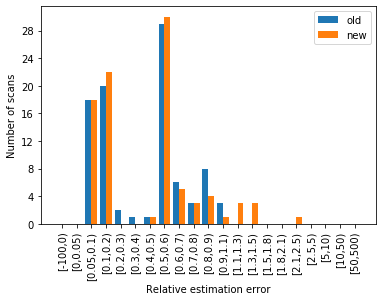

In [20]:
clustering.evaluation.print_aggregated_metrics(scan_results, m.query_frequencies)
fig = clustering.evaluation.plot_scan_errors(scan_results, old_scan_results, m.query_frequencies)
#old_scan_results = scan_results
fig

In [21]:
scan_results['e'] = scan_results['TOTAL_ERROR'] ** 2
scan_results['IMPLEMENTATION'] = scan_results.apply(lambda x: x['DESCRIPTION1'].split("Impl: ")[1].split()[0], axis=1)
scan_results['DESC'] = scan_results.apply(lambda x: " ".join(x['DESCRIPTION1'].split(" ")[3:]), axis=1)
scan_results.sort_values(['e'], ascending=False)[["QUERY_HASH", "DESC", "COLUMN_NAME", "RUNTIME_BASE", "RUNTIME_ESTIMATE", "RUNTIME_CLUSTERED", "TOTAL_ERROR", "RELATIVE_ERROR"]]
#scan_results['DESCRIPTION1'].apply(lambda x: "Like" in x).any()

,QUERY_HASH,DESC,COLUMN_NAME,RUNTIME_BASE,RUNTIME_ESTIMATE,RUNTIME_CLUSTERED,TOTAL_ERROR,RELATIVE_ERROR
16,4e4cb5b90ba5de03,l_shipdate <= '1998-08-04',l_shipdate,35531182,9005800,19950263,10944463,2.215268
39,6fb3f7e54d76ceed,l_shipdate <= '1998-09-27',l_shipdate,35856664,21715331,12801337,-8913994,0.589507
45,7a589f8ab18426d6,l_shipdate <= '1998-09-21',l_shipdate,38255098,21636078,12835910,-8800168,0.593264
4,3898d8ff5bfa1046,l_shipdate <= '1998-10-02',l_shipdate,42418676,21641693,13104188,-8537505,0.605507
29,5b8fbc10c745e39,l_receiptdate BETWEEN UPPER EXCLUSIVE '1993-01-01' AND '1994-01-01',l_receiptdate,17509851,7817493,1173270,-6644223,0.150083
78,ee94325d3e4bf0a8,l_receiptdate BETWEEN UPPER EXCLUSIVE '1997-01-01' AND '1998-01-01',l_receiptdate,16182082,7456062,1161395,-6294667,0.155765
88,fe56436b8c0d101,l_receiptdate BETWEEN UPPER EXCLUSIVE '1994-01-01' AND '1995-01-01',l_receiptdate,16157567,7494771,1208053,-6286718,0.161186
49,85c77cc53ff9fd3f,l_receiptdate BETWEEN UPPER EXCLUSIVE '1997-01-01' AND '1998-01-01',l_receiptdate,16004185,7456062,1175854,-6280208,0.157704
82,f2b5e28bd4c3992d,l_receiptdate BETWEEN UPPER EXCLUSIVE '1996-01-01' AND '1997-01-01',l_receiptdate,15699448,7326224,1134715,-6191509,0.154884
72,df6e2c89797dffb1,l_receiptdate BETWEEN UPPER EXCLUSIVE '1996-01-01' AND '1997-01-01',l_receiptdate,16172583,7326224,1138975,-6187249,0.155465
